In [1]:
require(ggplot2)
require(data.table)
require(Hmisc)

Loading required package: ggplot2
Loading required package: data.table
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



In [2]:
# If experiment parameters change, modify this function
AddParametersAsColumns <- function(df, folderName) {
    expParams <- strsplit(folderName, ".", fixed = TRUE)[[1]]
    
    expCloudParams <- strsplit(expParams[2], "_")[[1]]
    df$groupSizeDist <- expCloudParams[10]
    df$placementDist <- expCloudParams[11]
    df$colocateNumHostsPerLeaf <- if (expCloudParams[12] == "-1") "uniform" else expCloudParams[12]
    df$seed <- expCloudParams[15]
    
    expOptimizerParams <- strsplit(expParams[3], "_")[[1]]
    df$algorithm <- expOptimizerParams[2]
    df$numBitmaps <- expOptimizerParams[3]
    df$numLeafsPerBitmap <- expOptimizerParams[4]
    df$redundancyPerBitmap <- expOptimizerParams[5]
    df$numRulesPerLeaf <- expOptimizerParams[6]
    return(df)
}


# Turns all files of a given filname across a set of folders into a single dataset
DatasetAsDataTable <- function(filename, folders, headers, header=FALSE) {
    # Get list of data.frames
    dfList <- lapply(folders, function(folder) {
           tmp <- fread(paste(folder, filename, sep="/"), sep=",", header=header)
           tmp <- AddParametersAsColumns(tmp, folder)
    })
    
    # Combine into a single data.table
#     dt <- data.table(do.call(rbind, dfList))
    dt <- rbindlist(dfList)
    
    
    # Rename columns according to headers
    for (colIndex in seq(1, length(headers))) {
        setnames(dt, colnames(dt)[colIndex], headers[colIndex])
    }
    return(dt)
}

directory = "/mnt/sdb1/baseerat/numerical-evals/11-29-2017/logs-1M"
folders <- Sys.glob(paste(directory, "logs.*", sep='/'))
plotTheme <- theme(legend.title=element_blank(), legend.position="top", legend.text=element_text(size=6))

In [3]:
ruleCountPerLeaf <- DatasetAsDataTable("rule_count_per_leaf.csv", 
                                       folders, c("leafId", "numRules"))

In [4]:
head(ruleCountPerLeaf)

,leafId,numRules,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf
1,0,10000,uniform,colocate-random-random,12,0,exact-match,10,3,0,10000
2,1,10000,uniform,colocate-random-random,12,0,exact-match,10,3,0,10000
3,2,10000,uniform,colocate-random-random,12,0,exact-match,10,3,0,10000
4,3,10000,uniform,colocate-random-random,12,0,exact-match,10,3,0,10000
5,4,10000,uniform,colocate-random-random,12,0,exact-match,10,3,0,10000
6,5,10000,uniform,colocate-random-random,12,0,exact-match,10,3,0,10000


In [11]:
plotRuleCountPerLeaf = ruleCountPerLeaf[numRulesPerLeaf != 32000]

In [14]:
plt <- ggplot(plotRuleCountPerLeaf) +
    geom_boxplot(aes(y=numRules, x=factor(numBitmaps), 
                     fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
                 outlier.size=0.5) +
    facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
    xlab("Number of bitmaps") +
    ylab("Number of rules") +
    plotTheme

In [ ]:
ggsave(plt, file="rule_count_per_leaf.pdf")

In [19]:
groupCountPerTenant <- DatasetAsDataTable("group_count_per_tenant.csv", 
                                          folders, c("tenantId", "groupCount"))

In [24]:
groupCountPerTenant[algorithm == "exact-match" & colocateNumHostsPerLeaf == 48 & numBitmaps == 10 & 
                    numLeafsPerBitmap == 3 & numRulesPerLeaf == 10000 & groupSizeDist == "uniform",
                    quantile(groupCount, c(0.0, 0.5,0.99,0.999,0.9999,1.0)) #, by=list(groupSizeDist)
                   ]

0%      50%      99%    99.9%   99.99%     100% 
  18.000  181.000 4847.070 8746.140 9250.402 9272.000

In [25]:
vmCountPerTenant <- DatasetAsDataTable("vm_count_per_tenant.csv", folders, c("tenantId", "vmCount"))

In [28]:
vmCountPerTenant[algorithm == "exact-match" & colocateNumHostsPerLeaf == 48 & numBitmaps == 10 & 
                 numLeafsPerBitmap == 3 & numRulesPerLeaf == 10000 & groupSizeDist == "uniform",
                 quantile(vmCount, c(0.0, 0.5,0.99,0.999,0.9999,1.0))]

0%      50%      99%    99.9%   99.99%     100% 
  10.000   97.000 2596.210 4791.004 4987.301 4999.000

In [29]:
groupSizePerGroupPerTenant <- DatasetAsDataTable("group_size_per_group_per_tenant.csv", 
                                                 folders, c("groupId", "groupSize"))

Read 998466 rows and 2 (of 2) columns from 0.010 GB file in 00:00:13


ERROR: Error: cannot allocate vector of size 8.0 Gb


In [ ]:
groupSizePerGroupPerTenant[algorithm == "exact-match" & colocateNumHostsPerLeaf == 48 & numBitmaps == 10 & 
                           numLeafsPerBitmap == 3 & numRulesPerLeaf == 10000,
                           quantile(groupSize, 
                                    c(0.0, 0.5, 0.8, 0.99, 0.991, 0.992, 0.993, 
                                      0.994, 0.995, 0.996, 0.999, 0.9999, 1.0)), 
                           by=groupSizeDist]

In [5]:
groupsCoveredWithBitmapsOnly <- DatasetAsDataTable("groups_covered_with_bitmaps_only.csv", 
                                                   folders, c("index", "groupsCovered", "groupsCoveredWithoutDefaultBitmap"),
                                                   TRUE) # Shahbaz: adding this param as this file contains header line

In [7]:
trafficOverhead <- DatasetAsDataTable("traffic_overhead.csv", 
                                      folders, c("index", "trafficOverhead"))

In [6]:
leafSpineTraffic <- DatasetAsDataTable("leaf_spine_traffic_per_group_per_tenant.csv", 
                                       folders, c("groupId", "multicastTraffic", "unicastTraffic", "overlayTraffic",
                                                 "baseeratTraffic"),
                                       TRUE) # Shahbaz: adding this param as this file contains header line

In [ ]:
# head(ruleCountPerLeaf)
# head(groupCountPerTenant)
# head(groupSizePerGroupPerTenant)
# head(vmCountPerTenant)

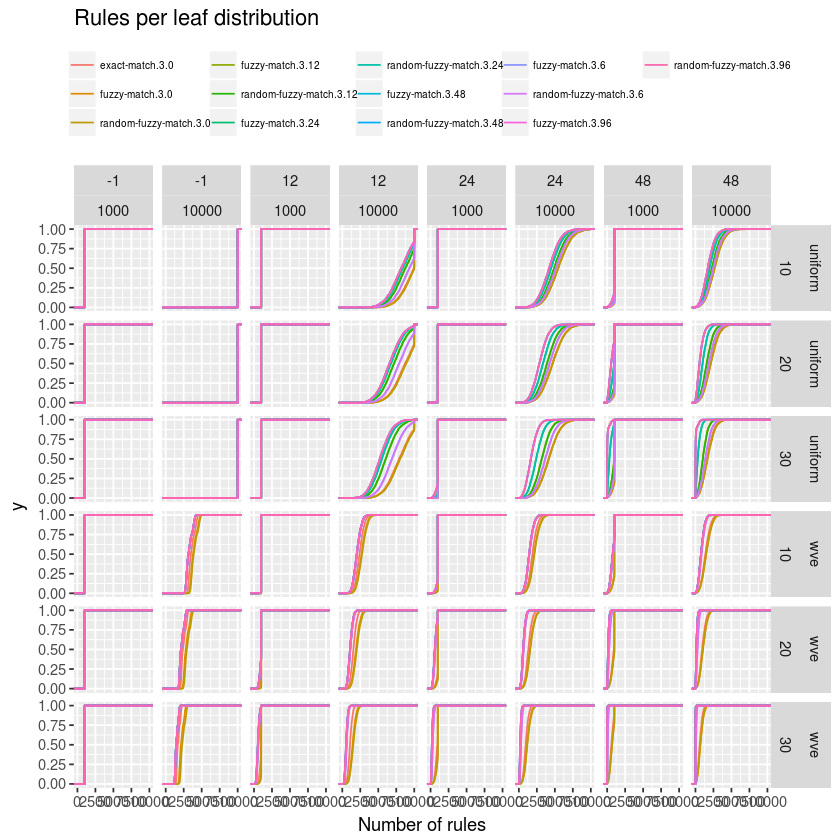

In [16]:
ggplot(ruleCountPerLeaf) +
   stat_ecdf(aes(x=numRules, col=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap))) +
   facet_grid(groupSizeDist * numBitmaps ~ colocateNumHostsPerLeaf * numRulesPerLeaf) +
   ggtitle("Rules per leaf distribution") +
   xlab("Number of rules") +
   plotTheme

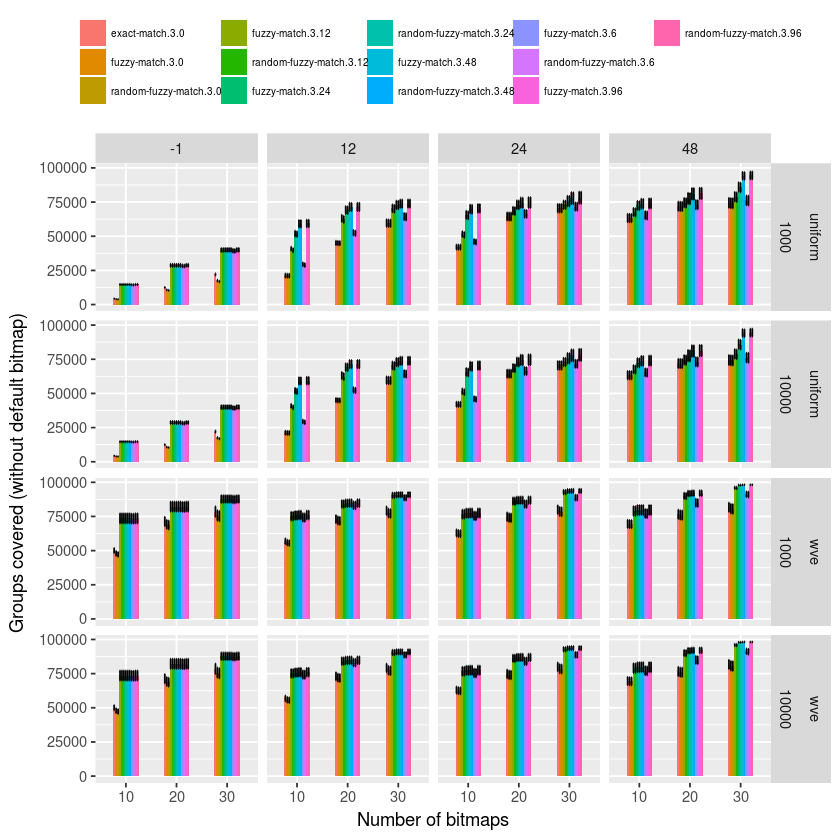

In [13]:
ggplot(groupsCoveredWithBitmapsOnly[numLeafsPerBitmap == 3], aes(y=groupsCoveredWithoutDefaultBitmap, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap))) +
   stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
   stat_summary(fun.data = mean_cl_normal, geom = "errorbar", position=position_dodge(0.5), width=0.2) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   xlab("Number of bitmaps") +
   ylab("Groups covered (without default bitmap)") +
   plotTheme

In [ ]:
ggplot(trafficOverhead) +
   geom_bar(aes(y=trafficOverhead, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
            stat="identity",position=position_dodge()) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme

In [8]:
overheads <- leafSpineTraffic[, list("UnicastSum" = sum(as.numeric(unicastTraffic)), 
                                     "MulticastSum" = sum(as.numeric(multicastTraffic)),
                                     "BaseeratSum" = sum(as.numeric(baseeratTraffic)),
                                     "OverlaySum" = sum(as.numeric(overlayTraffic))),
                              by=list(groupSizeDist, placementDist, colocateNumHostsPerLeaf, algorithm,
                                      numBitmaps, numLeafsPerBitmap, redundancyPerBitmap, numRulesPerLeaf, seed)]

In [9]:
head(overheads)

,groupSizeDist,placementDist,colocateNumHostsPerLeaf,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf,seed,UnicastSum,MulticastSum,BaseeratSum,OverlaySum
1,uniform,colocate-random-random,12,exact-match,10,3,0,10000,0,233305732,66135765,101456008,131877546
2,uniform,colocate-random-random,12,exact-match,10,3,0,1000,0,233305732,66135765,300597470,131877546
3,uniform,colocate-random-random,12,exact-match,20,3,0,10000,0,233305732,66135765,81898645,131877546
4,uniform,colocate-random-random,12,exact-match,20,3,0,1000,0,233305732,66135765,273852899,131877546
5,uniform,colocate-random-random,12,exact-match,30,3,0,10000,0,233305732,66135765,73386086,131877546
6,uniform,colocate-random-random,12,exact-match,30,3,0,1000,0,233305732,66135765,255510974,131877546


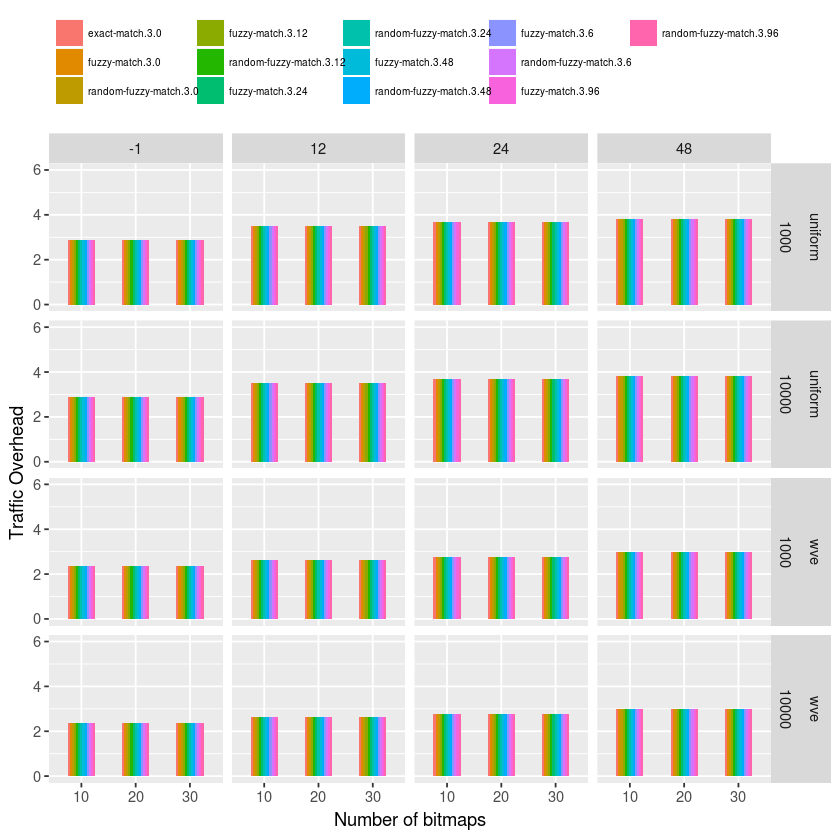

In [10]:
ggplot(overheads, aes(y=UnicastSum/MulticastSum, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap))) +
   stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.5), width=0.5) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   ylim(c(0, 6)) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

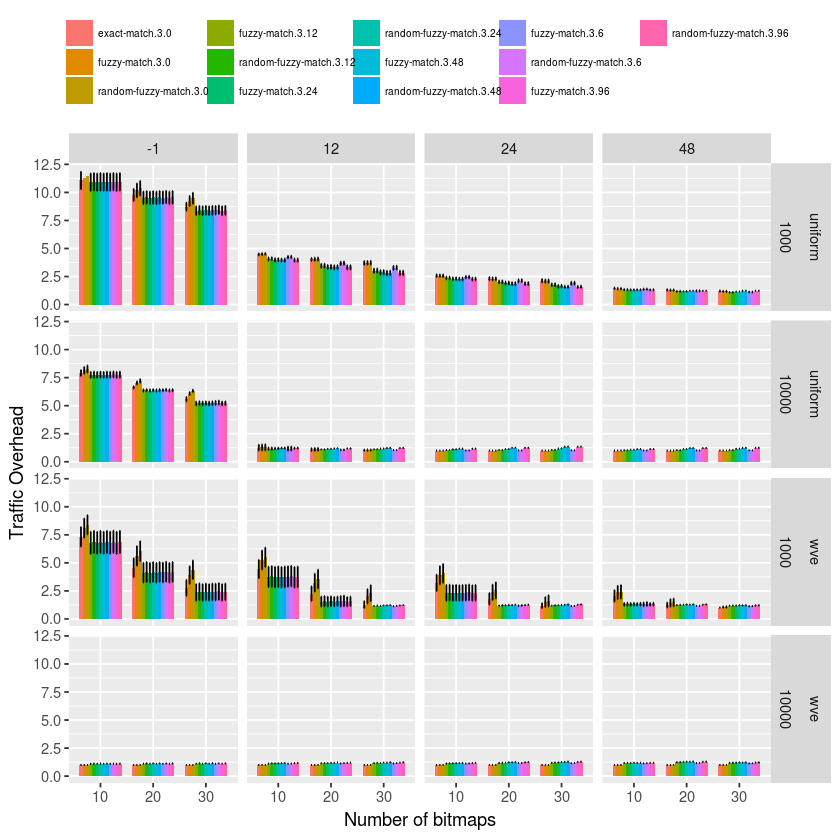

In [14]:
ggplot(overheads, aes(y=BaseeratSum/MulticastSum, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap))) +
   stat_summary(fun.y = mean, geom = "bar", position=position_dodge(0.8), width=0.8) +
   stat_summary(fun.data = mean_cl_normal, geom = "errorbar", position=position_dodge(0.8), width=0.2) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   ylim(c(0, 12)) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme

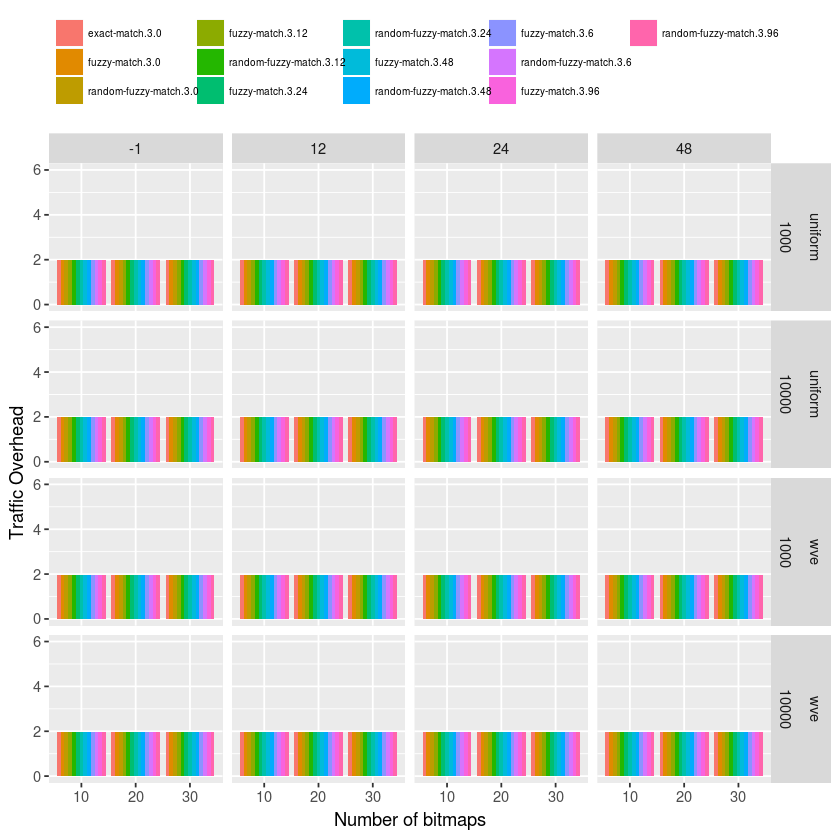

In [12]:
ggplot(overheads) +
   geom_bar(aes(y=OverlaySum/MulticastSum, x=factor(numBitmaps), 
                fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap)),
            stat="identity", position=position_dodge(),) +
   facet_grid(groupSizeDist * numRulesPerLeaf ~ colocateNumHostsPerLeaf) +
   ylim(c(0, 6)) +
   xlab("Number of bitmaps") +
   ylab("Traffic Overhead") +
   plotTheme